# NVIDIA Nsight Systems
[NVIDIA Nsight™ Systems](https://developer.nvidia.com/nsight-systems) is a system-wide performance analysis tool designed to visualize an application’s algorithms, help to identify the largest opportunities to optimize, and tune to scale efficiently across any quantity or size of CPUs and GPUs.

# NVIDIA Tools Extension (NVTX)
The [NVIDIA® Tools Extension Library (NVTX)](https://github.com/NVIDIA/NVTX) is a powerful mechanism that allows users to manually instrument their application. With a C-based and a python-based Application Programming Interface (API) for annotating events, code ranges, and resources in your applications. Applications which integrate NVTX can use NVIDIA Nsight, Tegra System Profiler, and Visual Profiler to capture and visualize these events and ranges. In general, the NVTX can bring valuable insight into the application while incurring almost no overhead.

# MONAI Training Pipeline and NVTX
[MONAI](https://github.com/Project-MONAI/MONAI) is a high level framework for deep learning in healthcare imaging.

For performance profiling, we mainly focus on two fronts: data loading/transforms, and training/validation iterations.

[Transforms](https://github.com/Project-MONAI/MONAI/tree/dev/monai/transforms) is one core concept of data handling in MONAI, similar to [TorchVision Transforms](https://pytorch.org/vision/stable/transforms.html). Several of these transforms are usually chained together, using a [Compose](https://github.com/Project-MONAI/MONAI/blob/2f1c7a5d1b47c8dd21681dbe1b67213aa3278cd7/monai/transforms/compose.py#L35) class, to create a preprocessing or postprocessing pipeline that performs manipulation of the input data and make it suitable for training a deep learning model or inference. To dig into the cost from each individual transform, we enable the insertion of NVTX annotations via [MONAI NVTX Transforms](https://github.com/Project-MONAI/MONAI/blob/dev/monai/utils/nvtx.py).

For training and validation steps, they are easier to track by setting NVTX annotations within the loop.


# Profiling Pathology Metastasis Detection Pipeline
## Install dependencies

In [ ]:
!pip install git+https://github.com/Project-MONAI/MONAI
!pip install tqdm
!pip install torchvision
!pip install cucim==21.8.2
!pip install cupy-cuda114
!pip install pytorch-ignite
!pip install nvidia-pyindex
!pip install nvidia-dlprof[pytorch]
!pip install nvtx

## Data Preparation

The pipeline that we are profiling `rain_evaluate_nvtx_profiling.py` requires [Camelyon-16 Challenge](https://camelyon16.grand-challenge.org/) dataset.  You can download all the images for "CAMELYON16" data set from sources listed [here](https://camelyon17.grand-challenge.org/Data/), as well as the coordinates and labels (`dataset_0.json`), from [here](/view?usp=sharing)

However, for the demo of this notebook, we are downloading a very small subset of Camelyon dataset, which uses only one whole slide image `tumor_091.tif` .

In [ ]:
import os
import gdown

# Download images
# by default the images expect to be under training/images/
image_dir = os.path.join("data", "training", "images", "")
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
image_url = "https://drive.google.com/uc?id=1OxAeCMVqH9FGpIWpAXSEJe6cLinEGQtF"
gdown.download(image_url, image_dir, quiet=False)

# Download datset.json
dataset_url = "https://drive.google.com/uc?id=1F-lR9tXoFkPkC1yueM-_TyaFk3CO7v0s"
dataset_path = os.path.join("data", "dataset_0.json")
gdown.download(dataset_url, dataset_path, quiet=False)


## Run Nsight Profiling 
We use `nsys profile` to get the information regarding the training pipeline's behavior across several steps. Since an epoch for pathology is long (covering 400,000 images), here we run profile on the trainer under basic settings for 30 seconds, with 50 seconds' delay. All results shown below are from experiments performed on a DGX-2 workstation using a single V-100 GPU.

In [ ]:
!nsys profile \
    --delay 50 \
    --duration 30 \
    --output ./output_base \
    --force-overwrite true \
    --trace-fork-before-exec true \
    python3 train_evaluate_nvtx.py --baseline

# Identify Potential Performance Improvements 
## Profile Results
After profiling, we visualize the computing details via Nsight System GUI. 

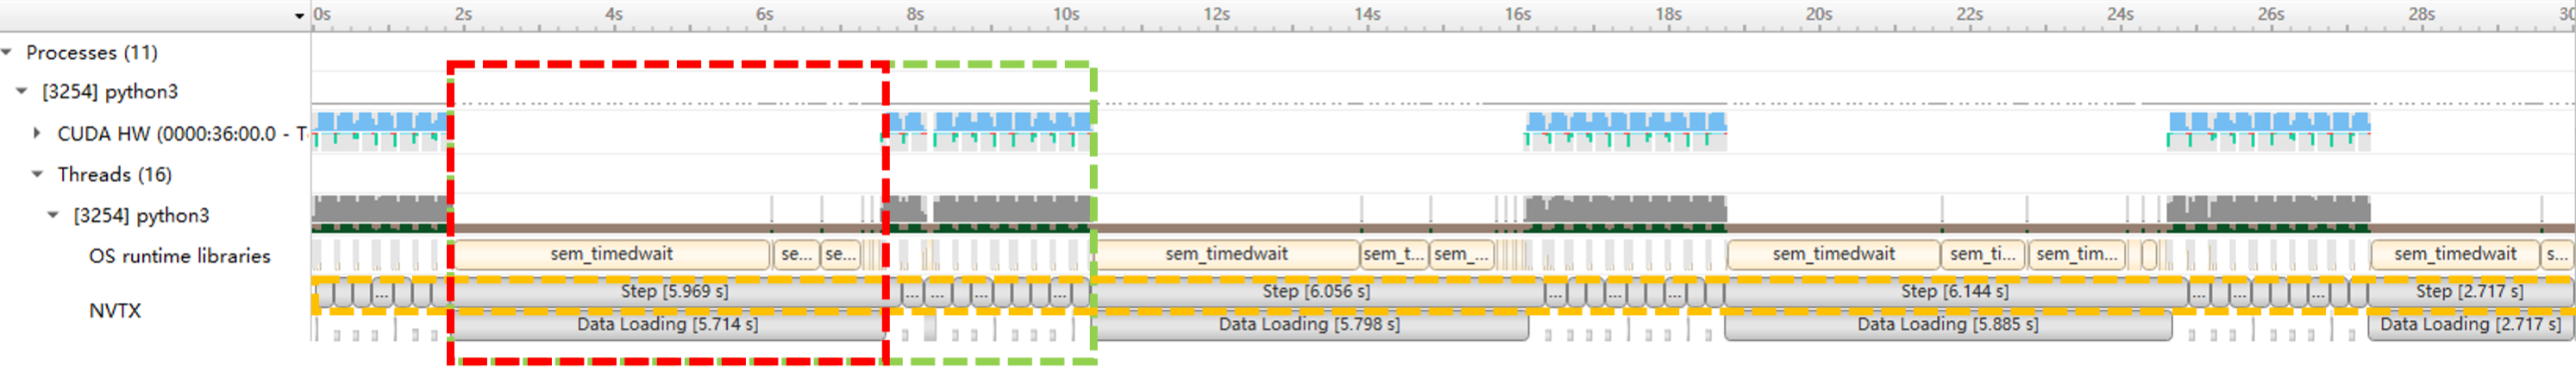

In [5]:
from IPython.display import display, Image
display(Image(filename="Figure/nsight_base.png", width=1200))

## Observations

As shown in the above figure, we focus on two sections: CUDA (first row), and NVTX (last two rows). Nsight provides information regarding GPU utilization (CUDA), and specific NVTX tags we added to track certain behaviors.
In this example, we added NVTX tags to track each training step, as well as operations within each step (data transforms, forward, backward, etc.). As shown within the orange dashed region, each solid block represents a single training step.

As can be observed from the figure, there are some clear patterns:

- During training steps, the GPU utilization is high (blue peaks in the first row) for GPU operation (network training and updates), and low (gaps between the peaks in the first row) for CPU operation (data loading and transform)
- Big gap / long step (red dashed region ~6 sec) every ~10 steps (green dashed region).
- During this long step, the major operation is data loading (last row).

Let's now take a closer look at what operations are being performed during the long data loading by zooming in to the beginning of the red dashed region.


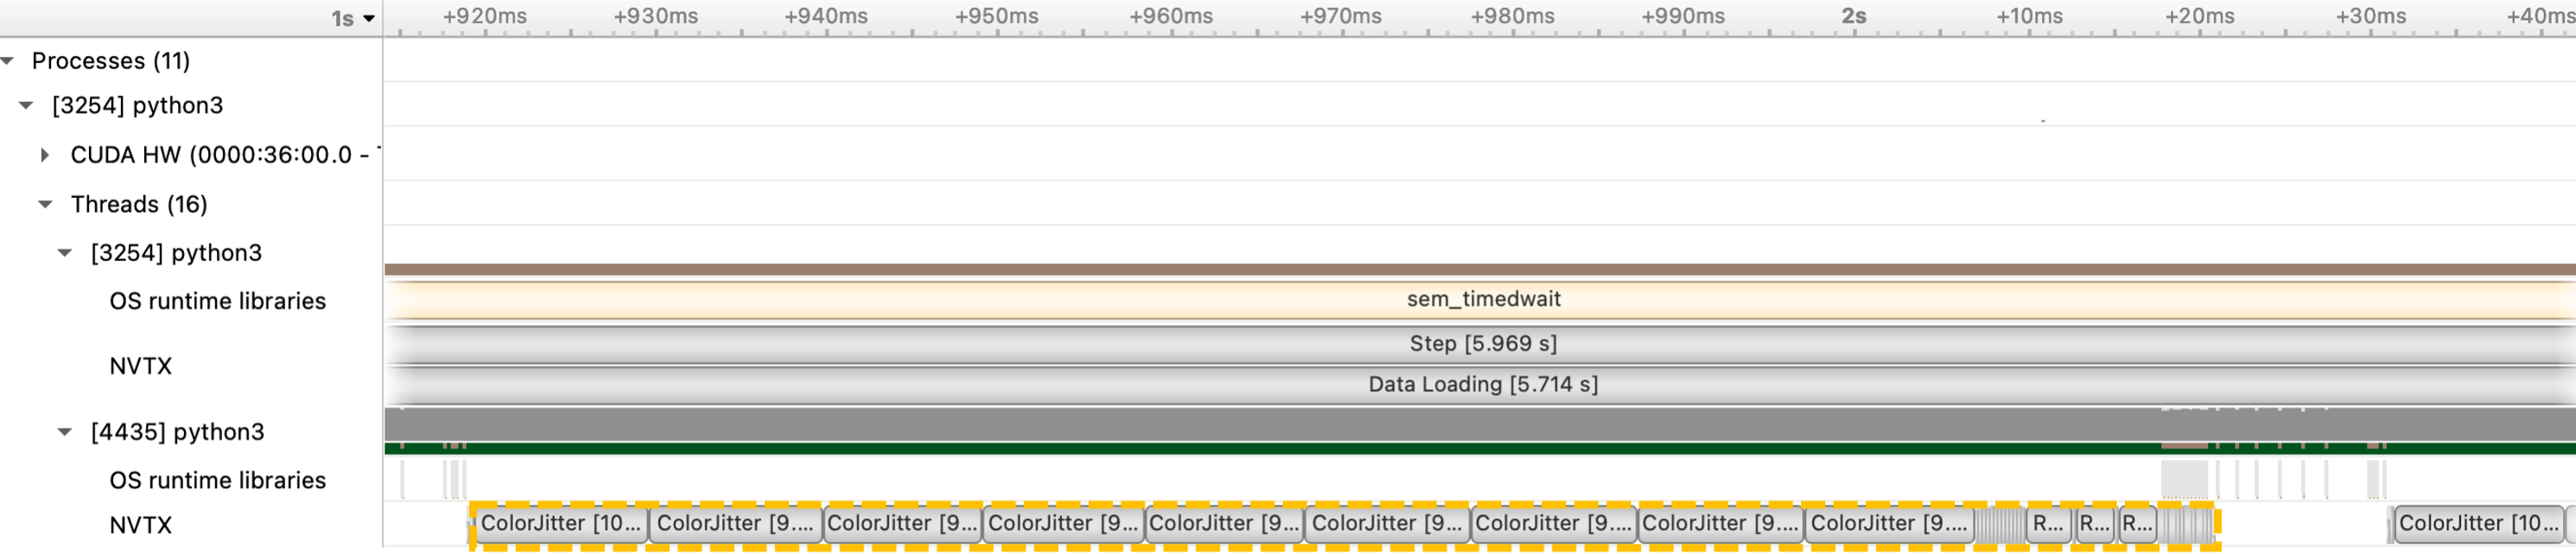

In [8]:
display(Image(filename="Figure/nsight_transform.png", width=1200))

As shown in the zoomed view, during the above "data loading" gap, the major operation is data transforms. To be more specific, most of the time is spent on "ColorJitter" operation (orange dashed region). This augmentation technique is a necessary transform for the task of pathology metastasis detection. For this pipeline, it is performed on CPU. On the other hand, the GPU training is so fast that it need to wait a long time for the data augmentation to finish, which comparably is much slower.

Therefore, as we identify this major bottleneck, we need to find a mechanism for faster data transform in order to achieve performance improvement.

One optimized solution can be found [here](https://github.com/Project-MONAI/tutorials/blob/master/acceleration/fast_training_tutorial.ipynb), for which we utilized CuCIM library's GPU transforms for data augmentation, so that all steps are performed on GPU, and thus this bottleneck from slow CPU augmentation can be removed.

# Analyzing Performance Improvement
## Profile Results
We again use Nsys Profile to further analyze the optimized training script.

In [ ]:
!nsys profile \
    --delay 50 \
    --duration 30 \
    --output ./output_base \
    --force-overwrite true \
    --trace-fork-before-exec true \
    python3 train_evaluate_nvtx.py --optimized

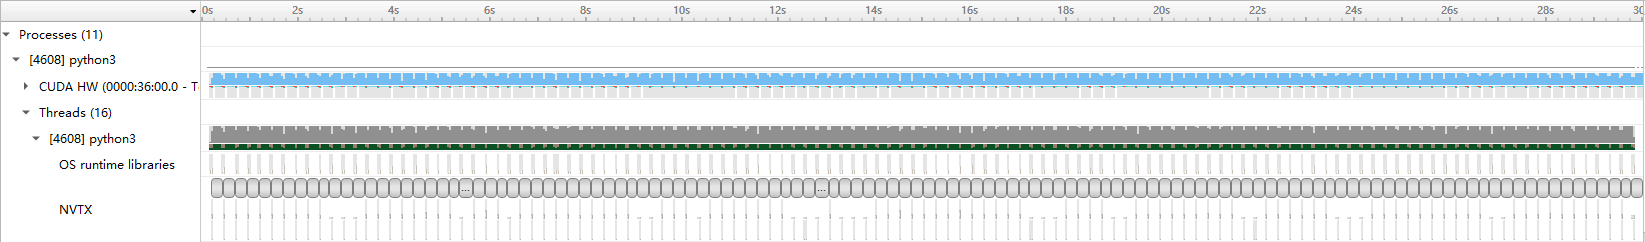

In [9]:
display(Image(filename="Figure/nsight_fast.png", width=1200))

As shown, the gaps caused by slow CPU augmentation are successfully removed.

Another profiling example for radiology image analysis can be found in the following [link](https://github.com/Project-MONAI/tutorials/blob/master/performance_profiling/pathology/profiling_train_base_nvtx.ipynb).